# **Projeto Jacurutu**
##### O Jacurutu (Corujão-orelhudo) é a maior ave de rapina noturna presente no Brasil, conhecida por sua visão e audição aguçada ela monitora seus alvos antes da caça. 
##### A ideia do projeto é a mesma, monitorar os dados em nossa floresta (Isolation Forest) de forma aguçada para encontrar outliers 🦉

### **A base de dados**
##### A base usada no projeto será a de extrato detalhado dos cartões de crédito corporativos do Governo Federal. Retirada diretamente do Portal da Transparencia, iremos analisar os gastos realziados desde 2023.
- URL de download: https://portaldatransparencia.gov.br/download-de-dados/cpgf
- Dicionário dos dados: https://portaldatransparencia.gov.br/dicionario-de-dados/cpgf

### Nesse notebook iremos fazer a etapa 4.1. Ingestão e Limpeza

In [2]:
#Importações
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Criando o dataset adicionando uma coluna indicando o arquivo original
csv_path = '../raw_data'
csv_files = [f for f in os.listdir(csv_path) if f.lower().endswith('.csv')]
dfs = []

## Fazer uma função
for file in csv_files:
    file_path = os.path.join(csv_path, file)
    df_temp = pd.read_csv(
        file_path,
        sep=';',
        encoding='latin-1',
        low_memory=False
    )
    df_temp['ARQUIVO ORIGEM'] = file
    dfs.append(df_temp)

CPGF_df = pd.concat(dfs, ignore_index=True)

In [4]:
# Formato função
def injetar_csvs_no_dataframe(csv_path):
    """
    Carrega todos os arquivos CSV do diretório Database CPGF no DataFrame CPGF_df,
    adicionando a coluna 'ARQUIVO ORIGEM' com o nome do arquivo csv original.
    """
    dfs = []
    csv_files = [f for f in os.listdir(csv_path) if f.lower().endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(csv_path, file)
        df_temp = pd.read_csv(file_path,sep=';',encoding='latin-1',low_memory=False)
        df_temp['ARQUIVO ORIGEM'] = file
        dfs.append(df_temp)
    CPGF_df = pd.concat(dfs, ignore_index=True)
    return CPGF_df

In [5]:
#Usando a função
CPGF_df = injetar_csvs_no_dataframe(csv_path)

In [6]:
CPGF_df_limpo = CPGF_df.copy()

In [7]:
# Analisando a base
CPGF_df_limpo.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392089 entries, 0 to 392088
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   CÓDIGO ÓRGÃO SUPERIOR   392089 non-null  int64 
 1   NOME ÓRGÃO SUPERIOR     392089 non-null  object
 2   CÓDIGO ÓRGÃO            392089 non-null  int64 
 3   NOME ÓRGÃO              392089 non-null  object
 4   CÓDIGO UNIDADE GESTORA  392089 non-null  int64 
 5   NOME UNIDADE GESTORA    392089 non-null  object
 6   ANO EXTRATO             392089 non-null  int64 
 7   MÊS EXTRATO             392089 non-null  int64 
 8   CPF PORTADOR            299427 non-null  object
 9   NOME PORTADOR           392089 non-null  object
 10  CNPJ OU CPF FAVORECIDO  392089 non-null  int64 
 11  NOME FAVORECIDO         392089 non-null  object
 12  TRANSAÇÃO               392089 non-null  object
 13  DATA TRANSAÇÃO          299427 non-null  object
 14  VALOR TRANSAÇÃO         392089 non-n

In [8]:
CPGF_df_limpo.tail()

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,CNPJ OU CPF FAVORECIDO,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO,ARQUIVO ORIGEM
392084,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,5,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"1492,92",202405_CPGF.csv
392085,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,5,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"246,46",202405_CPGF.csv
392086,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,5,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"135,84",202405_CPGF.csv
392087,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,5,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"736,55",202405_CPGF.csv
392088,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,5,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"129,00",202405_CPGF.csv


In [9]:
CPGF_df_limpo['TRANSAÇÃO'].value_counts()

TRANSAÇÃO
COMPRA A/V - R$ - APRES                259129
Informações protegidas por sigilo       92662
SAQUE CASH/ATM BB                       35173
COMPRA A/V - INT$ - APRES                3148
SAQUE - INT$ - APRES                     1967
CPP LOJISTA TRF P/FATURA - REAL             6
SAQUE - R$ - APRES                          3
COMP A/V-SOL DISP C/CLI-R$ ANT VENC         1
Name: count, dtype: int64

#### Pelas informações vamos separar a limpeza da base dos dados em 4 pontos:
1. Tratando colunas com dados faltantes
2. Corrigindo os tipos das colunas
3. Analisando e tratando a CNPJ OU CPF FAVORECIDO
4. Analisando e tratando a CPF PORTADOR

#### 1. Tratando dados faltantes

In [10]:
# Confirmando dados vazios/faltantes
colunas_vazias = (CPGF_df_limpo.isnull().sum() / len(CPGF_df_limpo)) * 100
print(colunas_vazias[colunas_vazias > 0])

CPF PORTADOR      23.6329
DATA TRANSAÇÃO    23.6329
dtype: float64


In [11]:
CPGF_df_limpo[CPGF_df_limpo['CPF PORTADOR'].isnull()]

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,CNPJ OU CPF FAVORECIDO,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO,ARQUIVO ORIGEM
672,52000,Ministério da Defesa,52111,Comando da Aeronáutica,120006,GRUPAMENTO DE APOIO DE BRASILIA,2025,1,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"532,00",202501_CPGF.csv
673,52000,Ministério da Defesa,52111,Comando da Aeronáutica,120006,GRUPAMENTO DE APOIO DE BRASILIA,2025,1,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"560,00",202501_CPGF.csv
674,52000,Ministério da Defesa,52111,Comando da Aeronáutica,120006,GRUPAMENTO DE APOIO DE BRASILIA,2025,1,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"161,46",202501_CPGF.csv
675,52000,Ministério da Defesa,52111,Comando da Aeronáutica,120006,GRUPAMENTO DE APOIO DE BRASILIA,2025,1,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"405,00",202501_CPGF.csv
676,52000,Ministério da Defesa,52111,Comando da Aeronáutica,120006,GRUPAMENTO DE APOIO DE BRASILIA,2025,1,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"4,00",202501_CPGF.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392084,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,5,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"1492,92",202405_CPGF.csv
392085,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,5,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"246,46",202405_CPGF.csv
392086,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,5,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"135,84",202405_CPGF.csv
392087,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,5,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,NaN,"736,55",202405_CPGF.csv


In [12]:
CPGF_df_limpo['VALOR TRANSAÇÃO'] = CPGF_df_limpo['VALOR TRANSAÇÃO'].astype(str).str.replace('.', '').str.replace(',', '.')
CPGF_df_limpo['VALOR TRANSAÇÃO'] = pd.to_numeric(CPGF_df_limpo['VALOR TRANSAÇÃO'], errors='coerce').fillna(0)

In [13]:
CPGF_df_limpo.describe()

,CÓDIGO ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,CÓDIGO UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CNPJ OU CPF FAVORECIDO,VALOR TRANSAÇÃO
count,392089.000000,392089.000000,392089.000000,392089.000000,392089.000000,3.920890e+05,392089.000000
mean,35781.050374,31606.052718,205768.689920,2023.956829,7.005101,1.530059e+13,684.496385
std,11380.887856,10540.820057,133733.576816,0.799001,3.188650,2.254988e+13,1988.643410
min,20000.000000,20101.000000,110001.000000,2023.000000,1.000000,-1.100000e+01,0.040000
25%,26000.000000,25205.000000,133088.000000,2023.000000,5.000000,-2.000000e+00,135.000000
50%,30000.000000,26433.000000,160367.000000,2024.000000,7.000000,4.610978e+12,380.000000
75%,47000.000000,32396.000000,200372.000000,2025.000000,10.000000,2.330670e+13,1000.000000
max,81000.000000,81000.000000,888310.000000,2025.000000,12.000000,9.874986e+13,207953.600000


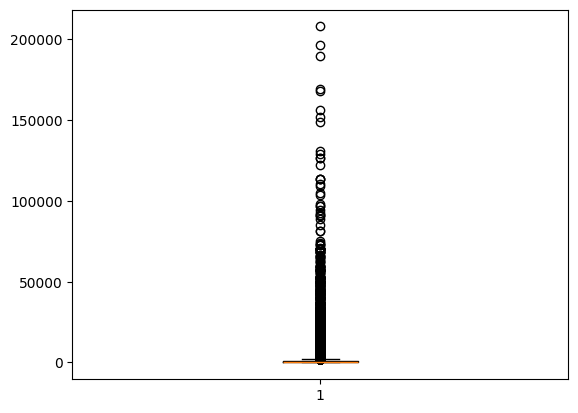

In [14]:
plt.boxplot(CPGF_df_limpo['VALOR TRANSAÇÃO'])
plt.show();

In [25]:
CPGF_df_limpo["VALOR TRANSAÇÃO"].max()

np.float64(207953.6)

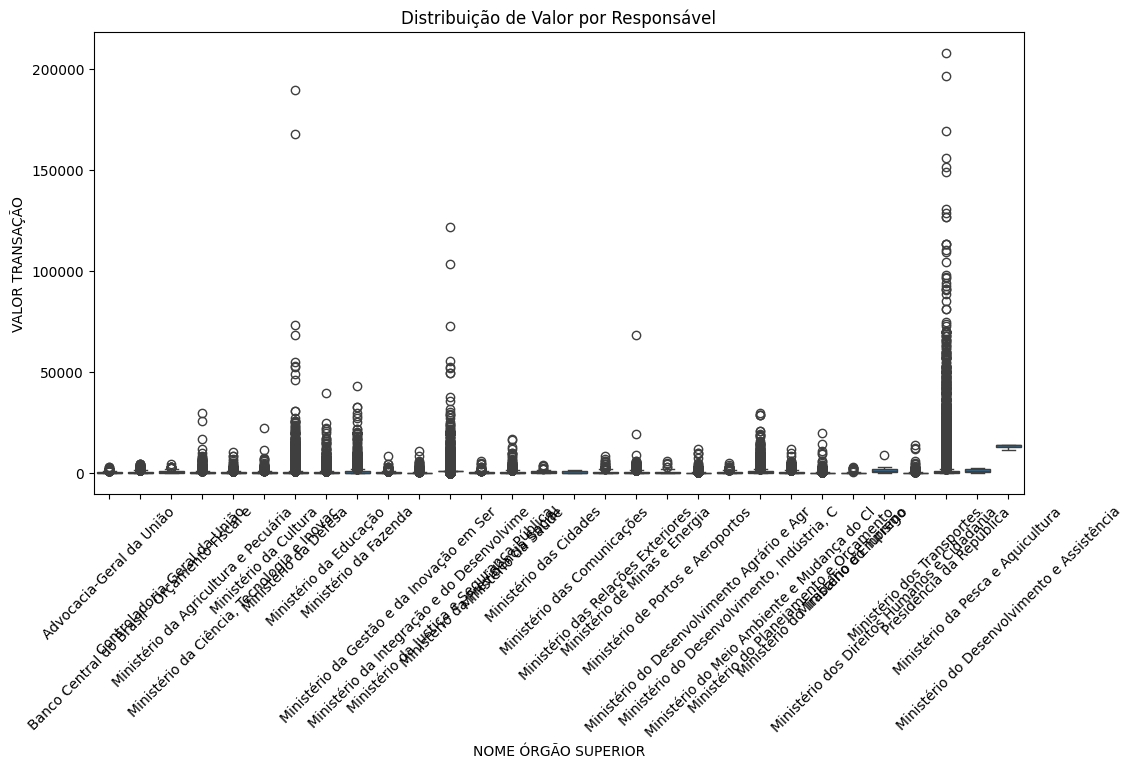

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=CPGF_df_limpo, x="NOME ÓRGÃO SUPERIOR", y="VALOR TRANSAÇÃO")

plt.xticks(rotation=45)
plt.title("Distribuição de Valor por Responsável")
plt.show()

In [16]:
summary_orgao = (
    CPGF_df_limpo.groupby("NOME ÓRGÃO SUPERIOR")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_orgao

,count,min,Q1,median,Q3,max,mean,sum,std
NOME ÓRGÃO SUPERIOR,,,,,,,,,
Ministério do Desenvolvimento e Assistência,3,11585.55,12837.4000,14089.250,14165.3750,14241.50,13305.433333,39916.30,1491.406727
Ministério dos Direitos Humanos e Cidadania,74,118.00,450.0000,1385.995,2232.1200,8950.00,1579.412568,116876.53,1350.702487
Ministério da Justiça e Segurança Pública,85122,0.60,1000.0000,1000.000,1000.0000,122038.19,996.896241,84857801.80,1321.765780
Ministério da Pesca e Aquicultura,19,179.90,575.0000,1000.000,2137.0000,2833.00,1341.494211,25488.39,868.246257
Ministério do Meio Ambiente e Mudança do Cl,8579,0.30,227.3250,695.860,1055.9000,30000.00,998.528088,8566372.47,1529.202116
Presidência da República,27705,0.20,161.7600,635.250,1000.0000,207953.60,1608.481056,44562967.67,6199.179197
Controladoria-Geral da União,224,13.80,225.0000,475.635,1089.5375,4762.50,767.165089,171844.98,784.983354
Ministério das Cidades,1132,0.89,188.5250,466.390,950.5000,4095.40,619.107164,700829.31,530.095661
Ministério das Comunicações,426,1.90,180.0000,400.000,985.2600,1800.00,558.512887,237926.49,457.706764


In [17]:
summary_unidade_gestora = (
    CPGF_df_limpo.groupby("NOME UNIDADE GESTORA")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_unidade_gestora

,count,min,Q1,median,Q3,max,mean,sum,std
NOME UNIDADE GESTORA,,,,,,,,,
COORDENACAO GERAL DE LICITACOES E CONTRATOS.,3,11585.55,12837.40,14089.25,14165.375,14241.50,13305.433333,39916.30,1491.406727
62 BATALHAO DE INFANTARIA,5,730.00,1000.00,10000.00,20000.000,49000.00,16146.000000,80730.00,19994.163648
1º BATALHAO DE INFANTARIA MECANIZADO (ES),1,6957.91,6957.91,6957.91,6957.910,6957.91,6957.910000,6957.91,NaN
FCDF±SSP ± POLICIA MILITAR DO DF,11,677.74,1670.55,6399.84,15674.500,29897.67,9831.068182,108141.75,9832.965975
BATALHAO MANUTENCAO E SUPRIMENTO DE ARMAMENTO,3,2760.00,3994.00,5228.00,6879.750,8531.50,5506.500000,16519.50,2895.811587
...,...,...,...,...,...,...,...,...,...
COMANDO DA 9A.REGIAO MILITAR,73,10.10,10.40,10.60,132.540,2609.10,209.125616,15266.17,555.803172
SUPERINTENDENCIA REG.DE MINAS GERAIS - SR(MG),855,1.93,9.60,10.20,40.500,2214.25,83.571860,71453.94,197.667202
INST.FED.DO RN/CAMPUS NATAL - CENTRAL,1,8.90,8.90,8.90,8.900,8.90,8.900000,8.90,NaN


In [18]:
summary_transacao = (
    CPGF_df_limpo.groupby("TRANSAÇÃO")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_transacao

,count,min,Q1,median,Q3,max,mean,sum,std
TRANSAÇÃO,,,,,,,,,
COMP A/V-SOL DISP C/CLI-R$ ANT VENC,1,1300.00,1300.00,1300.000,1300.00,1300.00,1300.000000,1.300000e+03,NaN
Informações protegidas por sigilo,92662,0.20,1000.00,1000.000,1000.00,207953.60,1230.852583,1.140533e+08,3514.193691
SAQUE - INT$ - APRES,1967,17.01,223.50,880.200,1270.70,4979.48,1065.172710,2.095195e+06,1017.039152
SAQUE CASH/ATM BB,35173,2.00,210.00,550.000,1000.00,1000.00,575.666079,2.024790e+07,363.696395
COMPRA A/V - R$ - APRES,259129,0.04,99.20,238.900,550.00,189650.00,497.163676,1.288295e+08,1048.668324
COMPRA A/V - INT$ - APRES,3148,0.06,49.39,159.575,458.40,122038.19,1002.109444,3.154641e+06,4941.421844
CPP LOJISTA TRF P/FATURA - REAL,6,91.07,91.07,91.070,91.07,91.07,91.070000,5.464200e+02,0.000000
SAQUE - R$ - APRES,3,50.00,65.00,80.000,540.00,1000.00,376.666667,1.130000e+03,540.030863


In [19]:
CPGF_df_limpo['CHAVE_PORTADOR'] = CPGF_df_limpo['CPF PORTADOR'] + CPGF_df_limpo['NOME PORTADOR']
summary_portador = (
    CPGF_df_limpo.groupby("CHAVE_PORTADOR")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_portador

,count,min,Q1,median,Q3,max,mean,sum,std
CHAVE_PORTADOR,,,,,,,,,
***.651.497-**JOAO GABRIEL CONCEICAO MARQUES,1,189650.00,189650.00,189650.00,189650.00,189650.00,189650.00,189650.00,NaN
***.425.562-**MATHEUS GUTTEMBERG ROCHA DOS SANTOS,2,52500.00,81375.00,110250.00,139125.00,168000.00,110250.00,220500.00,81670.833227
***.040.135-**MATHEUS OLIVEIRA COSTA,1,68479.74,68479.74,68479.74,68479.74,68479.74,68479.74,68479.74,NaN
***.844.951-**EUCIMAR DIOGENES DE MEDEIROS,1,29897.67,29897.67,29897.67,29897.67,29897.67,29897.67,29897.67,NaN
***.802.502-**MILTON MARTINS DA PENHA FILHO,1,29891.24,29891.24,29891.24,29891.24,29891.24,29891.24,29891.24,NaN
...,...,...,...,...,...,...,...,...,...
***.007.398-**ALAN CESAR DA CRUZ,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN
***.672.704-**LEANDRO FERREIRA DA SILVA,2,1.00,1.00,1.00,1.00,1.00,1.00,2.00,0.000000
***.890.293-**GIOVANNI MENDES GOES,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN


In [20]:
summary_favorecido = (
    CPGF_df_limpo.groupby("CNPJ OU CPF FAVORECIDO")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_favorecido

,count,min,Q1,median,Q3,max,mean,sum,std
CNPJ OU CPF FAVORECIDO,,,,,,,,,
63859961000176,2,52500.00,86787.50,121075.00,155362.50,189650.00,121075.00,242150.00,96979.695040
1200121000140,2,5700.00,46275.00,86850.00,127425.00,168000.00,86850.00,173700.00,114763.430587
5917540000158,1,68589.15,68589.15,68589.15,68589.15,68589.15,68589.15,68589.15,NaN
31702576000124,1,32999.00,32999.00,32999.00,32999.00,32999.00,32999.00,32999.00,NaN
26398202000127,1,32000.00,32000.00,32000.00,32000.00,32000.00,32000.00,32000.00,NaN
...,...,...,...,...,...,...,...,...,...
8934268000102,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN
34431280000104,2,1.00,1.00,1.00,1.00,1.00,1.00,2.00,0.000000
29783752000158,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN


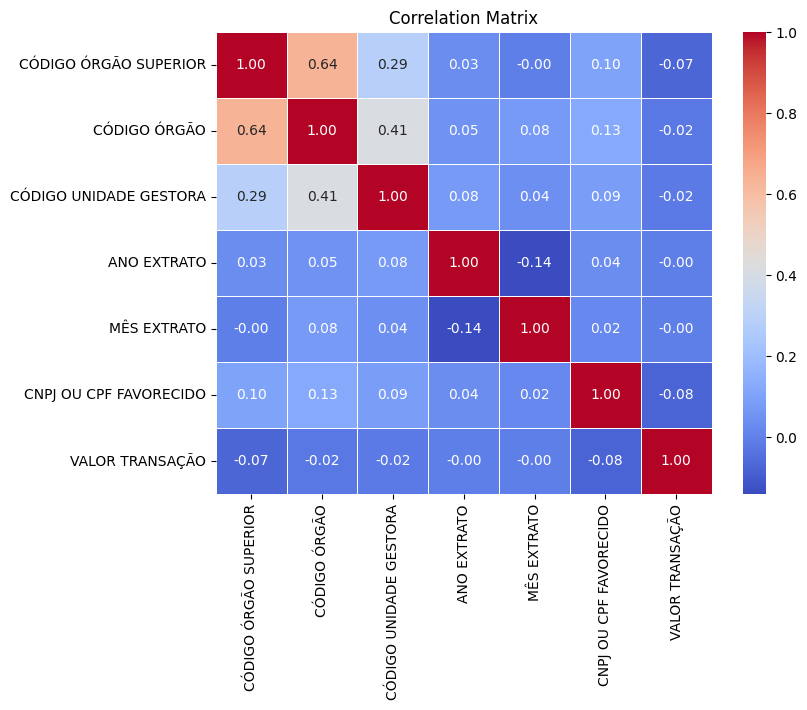

In [26]:
correlation_matrix = CPGF_df_limpo.corr(method='pearson', min_periods=1, numeric_only=True)
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

#### CNAE - Buscar informações via API

In [ ]:
import requests
import pandas as pd
import time

def get_cnpj_data(cnpj):
    """Busca dados de um CNPJ através da API da ReceitaWS."""
    url = f"https://www.receitaws.com.br/v1/cnpj/{cnpj}"
    try:
        response = requests.get(url)
        response.raise_for_status() # Lança um erro para códigos de status ruins
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Erro ao buscar CNPJ {cnpj}: {e}")
        return None

def process_and_classify(cnpj_list):
    """Processa uma lista de CNPJs e retorna um DataFrame com a classificação."""
    all_data = []
    for cnpj in cnpj_list:
        data = get_cnpj_data(cnpj)
        if data:
            atividade_principal = data.get('atividade_principal', [{}])[0].get('text', 'Não informado')
            natureza_juridica = data.get('natureza_juridica', 'Não informada')
            all_data.append({
                "cnpj": cnpj,
                "atividade_principal": atividade_principal,
                "natureza_juridica": natureza_juridica
            })
            time.sleep(20) # Aguarda 20 segundos para respeitar o limite da API
        else:
            all_data.append({
                "cnpj": cnpj,
                "atividade_principal": "Não encontrado",
                "natureza_juridica": "Não encontrada"
            })
    return pd.DataFrame(all_data)

# Exemplo de uso
cnpjs_para_consultar = ["00.000.000

##### Como a porcentagem de dados faltantes em ambas as colunas são **identicas**, podemos assumir que se tratam das mesmas linhas. Embora possamos imputar o 'CPF do portador' usando a coluna 'nome do portador', infelizmente não conseguimos imputar a data da transação, portanto optei por 'dropar' essas linhas.

In [ ]:
# Excluindo dados faltantes
colunas_drop = ['DATA TRANSAÇÃO', 'CPF PORTADOR']

linhas_antes = len(CPGF_df_limpo)
CPGF_df_limpo = CPGF_df_limpo.dropna(subset=colunas_drop)
linhas_removidas = linhas_antes - len(CPGF_df_limpo)

print(f"{linhas_removidas} linhas foram removidas.")
print(f"Total de linhas final no df_limpo: {len(CPGF_df_limpo)}")

In [ ]:
# Confirmando a exclusão
colunas_vazias = (CPGF_df_limpo.isnull().sum() / len(CPGF_df_limpo)) * 100
print(colunas_vazias[colunas_vazias > 0])

#### 2. Corrigindo os tipos das colunas

In [ ]:
# Ajustando coluna de Data
CPGF_df_limpo['DATA TRANSAÇÃO'] = pd.to_datetime(CPGF_df_limpo['DATA TRANSAÇÃO'], format='%d/%m/%Y', errors='coerce')

# Ajustando coluna de Valores
CPGF_df_limpo['VALOR TRANSAÇÃO'] = CPGF_df_limpo['VALOR TRANSAÇÃO'].astype(str).str.replace('.', '').str.replace(',', '.')
CPGF_df_limpo['VALOR TRANSAÇÃO'] = pd.to_numeric(CPGF_df_limpo['VALOR TRANSAÇÃO'], errors='coerce').fillna(0)

#### 3. Analisando e tratando a CNPJ OU CPF FAVORECIDO
##### Para tratar a coluna 'CNPJ ou CPF favorecido' de forma consistente e garantir que ela contenha documentos válidos (11 ou 14 dígitos), vamos separar os registros por tamanho e depois aplicar validações específicas para cada tipo. 

In [ ]:
# Verificando todos os tamanhos possíveis
CPGF_df_limpo['CNPJ OU CPF FAVORECIDO'] = CPGF_df_limpo['CNPJ OU CPF FAVORECIDO'].astype(str)
tamanhos = CPGF_df_limpo['CNPJ OU CPF FAVORECIDO'].str.len().value_counts().sort_index()
print(tamanhos)

In [ ]:
tamanhos_problematicos = [2, 4, 6, 7, 8, 9, 10, 12, 13]
serie_tamanhos = CPGF_df_limpo['CNPJ OU CPF FAVORECIDO'].str.len()

for tamanho in tamanhos_problematicos:
    print(f"Valores Mais Comuns para Tamanho = {tamanho}")
    valores_deste_tamanho = CPGF_df_limpo['CNPJ OU CPF FAVORECIDO'][serie_tamanhos == tamanho]
    print(valores_deste_tamanho.value_counts().head(5))

##### Pelos dados mais comuns é possível entender que muitos dos dados divergentes estão dessa forma por falta do 0 à esquerda. Exemplo '1060735000173' tem como final um claro comportamento de documento CNPJ /0001-73 faltando somente um zero à esquera para completar o documento.
##### Outro ponto é a coluna **Nome Favorecido** que é a contraparte ao documento onde foi gasto o valor.

##### Com isso vamos usar 2 estratégias para o imputar esses valores:
1. Zeros à esquera: Usaremos nos dados com tamanhos próximos ao correto
2. Investigação a partir dos Nomes: Usaremos nos dados restantes

##### 3.1 Zeros à esquerda

In [ ]:
CPGF_df_limpo['CNPJ OU CPF FAVORECIDO CORRIGIDO'] = CPGF_df_limpo['CNPJ OU CPF FAVORECIDO']

mascara_cpf_fix = (serie_tamanhos >= 8) & (serie_tamanhos <= 10)
mascara_cnpj_fix = (serie_tamanhos == 12) | (serie_tamanhos == 13)

# Padding CPF
CPGF_df_limpo.loc[mascara_cpf_fix, 'CNPJ OU CPF FAVORECIDO CORRIGIDO'] = CPGF_df_limpo['CNPJ OU CPF FAVORECIDO'][mascara_cpf_fix].str.pad(width=11, side='left', fillchar='0')

# Padding CNPJ
CPGF_df_limpo.loc[mascara_cnpj_fix, 'CNPJ OU CPF FAVORECIDO CORRIGIDO'] = CPGF_df_limpo['CNPJ OU CPF FAVORECIDO'][mascara_cnpj_fix].str.pad(width=14, side='left', fillchar='0')

In [ ]:
tamanhos_antigos_dist = serie_tamanhos.value_counts().sort_index()

tamanhos_novos_series = CPGF_df_limpo['CNPJ OU CPF FAVORECIDO CORRIGIDO'].str.len()
tamanhos_novos_dist = tamanhos_novos_series.value_counts().sort_index()

total_problematico_antes = serie_tamanhos[~serie_tamanhos.isin([11, 14])].count()
total_problematico_depois = tamanhos_novos_series[~tamanhos_novos_series.isin([11, 14])].count()
recuperados = total_problematico_antes - total_problematico_depois

print(tamanhos_novos_dist)

print(f"Linhas problemáticas originais (tamanho != 11 ou 14): {total_problematico_antes}")
print(f"Linhas problemáticas restantes (tamanho != 11 ou 14): {total_problematico_depois}")
print(f"LINHAS RECUPERADAS: {recuperados}")

##### 3.2 Investigando os nomes dos favorecidos

In [ ]:
coluna_corrigida = 'CNPJ OU CPF FAVORECIDO CORRIGIDO'
coluna_nome = 'NOME FAVORECIDO'

tamanhos_problematicos_restantes = [2, 4, 6, 7]
serie_tamanhos_novos = CPGF_df_limpo[coluna_corrigida].str.len()

dados_incompletos = serie_tamanhos_novos.isin(tamanhos_problematicos_restantes)
df_dados_incompletos = CPGF_df_limpo[dados_incompletos]

print(f"{len(df_dados_incompletos)} linhas sem informação de CNPJ favorecido.")
print(df_dados_incompletos[coluna_nome].value_counts())

Manualmente conseguimos encontrar o CNPJ do Banco do Brasil SA que é 00000000000191.

In [ ]:
nome_alvo = 'BANCO DO BRASIL SA'
cnpj_correto = '00000000000191'
coluna_nome = 'NOME FAVORECIDO'
coluna_corrigida = 'CNPJ OU CPF FAVORECIDO CORRIGIDO'

mascara_alvo = (CPGF_df_limpo[coluna_nome] == nome_alvo)
CPGF_df_limpo.loc[mascara_alvo, coluna_corrigida] = cnpj_correto

##### Dos nomes dos dados de favorecidos 2 se destacam pela volumetria e mensagem, NAO SE APLICA e SEM INFORMACAO. Por mais que eles não tenha um CNPJ/CPF direto associado, essas informações são **muito importantes**, pois eles significam que estas transações que não possuem dados diretos de favorecido declarados.
##### Como iremos usar o Isolation Forest para nossa análise futura, já pensando em como vamos classificar cada tipo de feature, iremos criar uma categoria para o favorecido informado em cada uma dessas transações.

##### 3.3 Criando a classificação de favorecido

In [ ]:
condicoes = [(serie_tamanhos == 11), (serie_tamanhos == 14), (serie_tamanhos == 2)]
categorias = ['CPF','CNPJ','NAO_INFORMADO']

CPGF_df_limpo['TIPO FAVORECIDO'] = np.select(condicoes,categorias,default='INVALIDO')

In [ ]:
# Drop nos favorecidos não classificados
linhas_para_dropar = CPGF_df_limpo[CPGF_df_limpo['TIPO FAVORECIDO'] == 'INVALIDO'].index
CPGF_df_limpo = CPGF_df_limpo.drop(linhas_para_dropar)

In [ ]:
# Analisando a nova feature
print("Contagem de linhas por categoria:")
print(CPGF_df_limpo['TIPO FAVORECIDO'] .value_counts())

In [ ]:
# Substituindo a CNPJ OU CPF FAVORECIDO pela CNPJ OU CPF FAVORECIDO CORRIGIDO
CPGF_df_limpo = CPGF_df_limpo.drop(columns=['CNPJ OU CPF FAVORECIDO'])
CPGF_df_limpo = CPGF_df_limpo.rename(columns={'CNPJ OU CPF FAVORECIDO CORRIGIDO':'CNPJ OU CPF FAVORECIDO'})

#### 4. Analisando e tratando a CPF PORTADOR

In [ ]:
tamanhos_cpf_portador = CPGF_df_limpo['CPF PORTADOR'].str.len().value_counts().sort_index()
print(tamanhos_cpf_portador)

##### Como o formato dos CPFs está de acordo com o esperado, não será necessário fazer alterações nesta coluna.

In [ ]:
CPGF_df_limpo.info()